In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 


import os 
import datetime 
from pathlib import Path

In [2]:
# point to the data dir 


path = Path('../data/')


dataverse_path =  path / 'dataverse_files'



partitions_list = [
    'partition1_instances', 
    'partition2_instances',
    'partition3_instances',
    'partition4_instances', 
    'partition5_instances'
    
    ]


      

def check_structure(partitions_list, dataverse_path):
    for partition_inst in partitions_list:
        partition_inst_path = dataverse_path / partition_inst
        if partition_inst_path.exists() and partition_inst_path.is_dir():
            print(f"{partition_inst}:")
            
            # extract partition number (e.g., "partition1" from "partition1_instances")
            partition_num = partition_inst.replace('_instances', '')
            
            # look for the actual partition folder inside
            partition_folder_path = partition_inst_path / partition_num
            
            if partition_folder_path.exists():
                print(f"  Found {partition_num} folder")
                for folder in ['FL', 'NF']:
                    folder_path = partition_folder_path / folder
                    if folder_path.exists() and folder_path.is_dir():
                        num_files = len(list(folder_path.glob('*.csv')))
                        print(f"    {folder}: {num_files} files")
                    else:
                        print(f"    {folder} folder is missing")
            else:
                print(f"  {partition_num} folder not found inside {partition_inst}")
            print()
        else:
            print(f"{partition_inst} directory does not exist")



check_structure(partitions_list, dataverse_path)



partition1_instances:
  Found partition1 folder
    FL: 1254 files
    NF: 72238 files

partition2_instances:
  Found partition2 folder
    FL: 1401 files
    NF: 87156 files

partition3_instances:
  Found partition3 folder
    FL: 1424 files
    NF: 41086 files

partition4_instances:
  Found partition4 folder
    FL: 1165 files
    NF: 50096 files

partition5_instances:
  Found partition5 folder
    FL: 990 files
    NF: 74375 files



In [3]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from threading import Lock
import re

def parse_partition(partitions_list, dataverse_path, filename=None, max_workers=8):
    ''' okay so in each partition theres a folder for partitionX_instances/partitionX/FL and /NF 
    
    FL  and NF represent flare and non-flare instances respectively
    FL represents the multivariate time series data samples that have a flare event occur within 24 hours of the observation,
    whereas NF represents those that do not have a flare event within that time frame.
    
    within the NF and FL folders are multiple csv files each representing a single data sample instance the name of each 

    NF and FL have the same naming conventions too. 

    M1.0@265:Primary_ar115_s2010-08-06T08:36:00_e2010-08-06T20:24:00.csv

    This shows an M1 sized flare within 24 hours of the sample. This is the 265th flare
    _ar115 indicates the active region number that the flare originates from 
    _s2010-08-06T08:36:00 indicates the start time of the sample
    _e2010-08-06T20:24:00 indicates the end time of the sample

    files that dont contain the @ symbol and begin with FQ dont have any flare occuring within 24 hours of the sample .

    NF still has flares but theyre very small and we can basically consider them as No Flare given the radition is comparable to background levels.
    ''' 

    # First pass: collect all files to show total progress
    all_files = []
    for partition_inst in partitions_list:
        partition_inst_path = dataverse_path / partition_inst
        partition_num = partition_inst.replace('_instances', '')
        partition_folder_path = partition_inst_path / partition_num
        
        for folder in ['FL', 'NF']:
            folder_path = partition_folder_path / folder
            if folder_path.exists() and folder_path.is_dir():
                for file in folder_path.glob('*.csv'):
                    all_files.append((file, folder, partition_num))
    
    # parsing an individual file
    def parse_file(file_info):
        ''' helper funcrtion to parse individual file 
            scrapes filename for relevant info and returns as dict to append to a df later 


            got a bunch of regexes to take care of the parsing here.
        '''
        file, class_label, partition_num = file_info
        filename = file.stem
        
        parsed_info = {
            'filename': filename,
            'class': class_label,
            'flare_id': None,
            'flare_size': None,
            'active_region': None,
            'start_time': None,
            'end_time': None,
            'partition': partition_num
        }
        
        # Parse filename - handle both FL and NF cases
        if '@' in filename:
            # Format: M1.0@265:Primary_ar115_s2010-08-06T08:36:00_e2010-08-06T20:24:00
            flare_part, rest = filename.split('@', 1)
            parsed_info['flare_size'] = flare_part.strip()
            
            flare_id_part, location_part = rest.split(':', 1)
            parsed_info['flare_id'] = flare_id_part.strip()
            
            # Parse active region and times
            ar_match = re.search(r'_ar(\d+)', location_part)
            if ar_match:
                parsed_info['active_region'] = ar_match.group(1)
            
            start_match = re.search(r'_s(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})', location_part)
            if start_match:
                parsed_info['start_time'] = start_match.group(1)
            
            end_match = re.search(r'_e(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})', location_part)
            if end_match:
                parsed_info['end_time'] = end_match.group(1)
        else:
            # NF case - parse similar format without flare ID


            # if filename.startswith('FQ'):
            #     parsed_info['flare_size'] = 'A'

            ar_match = re.search(r'_ar(\d+)', filename)
            if ar_match:
                parsed_info['active_region'] = ar_match.group(1)
            
            start_match = re.search(r'_s(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})', filename)
            if start_match:
                parsed_info['start_time'] = start_match.group(1)
            
            end_match = re.search(r'_e(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2})', filename)
            if end_match:
                parsed_info['end_time'] = end_match.group(1)
        
        return parsed_info
    
    # call threads here ( pls run this threaded )
    all_results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(parse_file, file_info): file_info for file_info in all_files}
        
        # TQDM progress bar
        with tqdm(total=len(all_files), desc="Parsing files", unit="file") as pbar:
            for future in as_completed(futures):
                result = future.result()
                all_results.append(result)
                pbar.update(1)
    

    results_df = pd.DataFrame(all_results)
    return results_df


result = parse_partition(partitions_list, dataverse_path, filename=None)
print(f"\nTotal files parsed: {len(result)}")
result.head()

Parsing files: 100%|██████████| 331185/331185 [00:01<00:00, 330080.64file/s]



Total files parsed: 331185


,filename,class,flare_id,flare_size,active_region,start_time,end_time,partition
0,FQ_ar5099_s2015-01-23T06:36:00_e2015-01-23T18:...,NF,None,None,5099,2015-01-23T06:36:00,2015-01-23T18:24:00,partition4
1,B9.1@10451:Secondary_ar5550_s2015-05-16T10:12:...,NF,10451,B9.1,5550,2015-05-16T10:12:00,2015-05-16T22:00:00,partition5
2,M2.1@11065:Primary_ar5956_s2015-09-20T00:12:00...,FL,11065,M2.1,5956,2015-09-20T00:12:00,2015-09-20T12:00:00,partition5
3,FQ_ar3647_s2014-01-28T20:00:00_e2014-01-29T07:...,NF,None,None,3647,2014-01-28T20:00:00,2014-01-29T07:48:00,partition3
4,FQ_ar3921_s2014-04-05T10:12:00_e2014-04-05T22:...,NF,None,None,3921,2014-04-05T10:12:00,2014-04-05T22:00:00,partition3


In [4]:
result.to_csv('../data/parsed_partition_metadata.csv', index=False) # makes life easier i guess??

In [5]:
result['partition'].value_counts()

partition
partition2    88557
partition5    75365
partition1    73492
partition4    51261
partition3    42510
Name: count, dtype: int64

In [6]:
result['flare_size'].value_counts()

flare_size
C1.1    2092
C1.2    1814
C1.0    1755
C1.3    1606
C1.4    1475
        ... 
M7.2       8
M7.4       8
C9.4       4
M7.1       4
M5.4       1
Name: count, Length: 260, dtype: int64

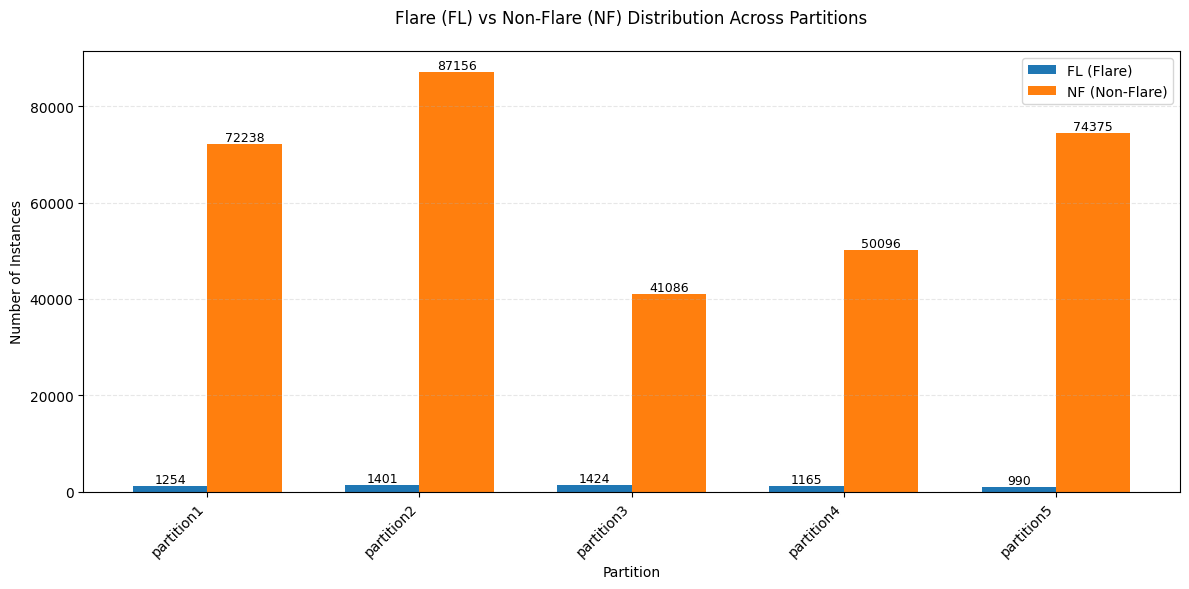

In [7]:
# tally the NF and FL cases for each partition
partition_counts = result.groupby(['partition', 'class']).size().unstack(fill_value=0)


fig, ax = plt.subplots(figsize=(12, 6))


x = range(len(partition_counts.index))
width = 0.35

#bar instances
bars1 = ax.bar([i - width/2 for i in x], partition_counts['FL'], width, 
               label='FL (Flare)')
bars2 = ax.bar([i + width/2 for i in x], partition_counts['NF'], width, 
               label='NF (Non-Flare)')

# plot labelling
ax.set_xlabel('Partition')
ax.set_ylabel('Number of Instances')
ax.set_title('Flare (FL) vs Non-Flare (NF) Distribution Across Partitions', 
              pad=20)
ax.set_xticks(x)
ax.set_xticklabels(partition_counts.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3, linestyle='--')


for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


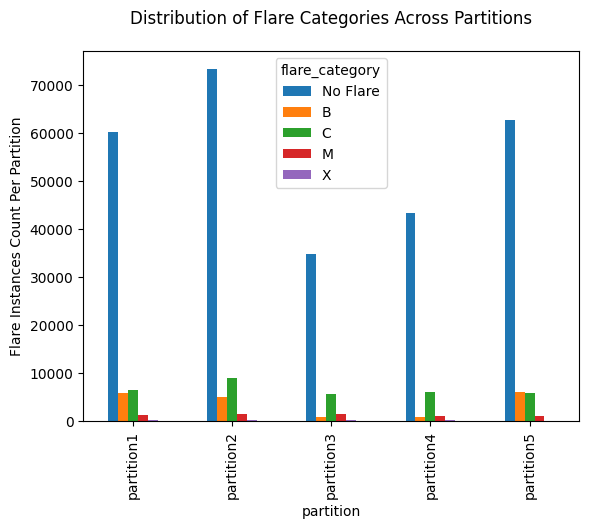

flare_category  No Flare     B     C     M    X
partition                                      
partition1         60130  5692  6416  1089  165
partition2         73368  4978  8810  1329   72
partition3         34762   685  5639  1288  136
partition4         43294   846  5956  1012  153
partition5         62688  5924  5763   971   19


In [8]:


# There are more catgories other than A,B,C,M,X each categories hace indicator letter followed by a number indicating the strength within that category
# ibr we only reallyc care about the first letter for categorization purposes
result['flare_category'] = result['flare_size'].apply(
    lambda x: x[0] if pd.notna(x) else 'No Flare' # litch just handle NaNs
)

# tally occurrences per partition and flare category
flare_counts = result.groupby(['partition', 'flare_category']).size().unstack(fill_value=0)

# No Flare is represennted by a NaN so we need to tally that 
categories = ['No Flare', 'B', 'C', 'M', 'X']
for cat in categories:
    if cat not in flare_counts.columns:
        flare_counts[cat] = 0
flare_counts = flare_counts[categories]

#plot
flare_counts.plot(kind='bar')
plt.ylabel('Flare Instances Count Per Partition')
plt.title('Distribution of Flare Categories Across Partitions', pad=20)
plt.show()


print(flare_counts)

In [9]:
result['active_region'].nunique()

3205

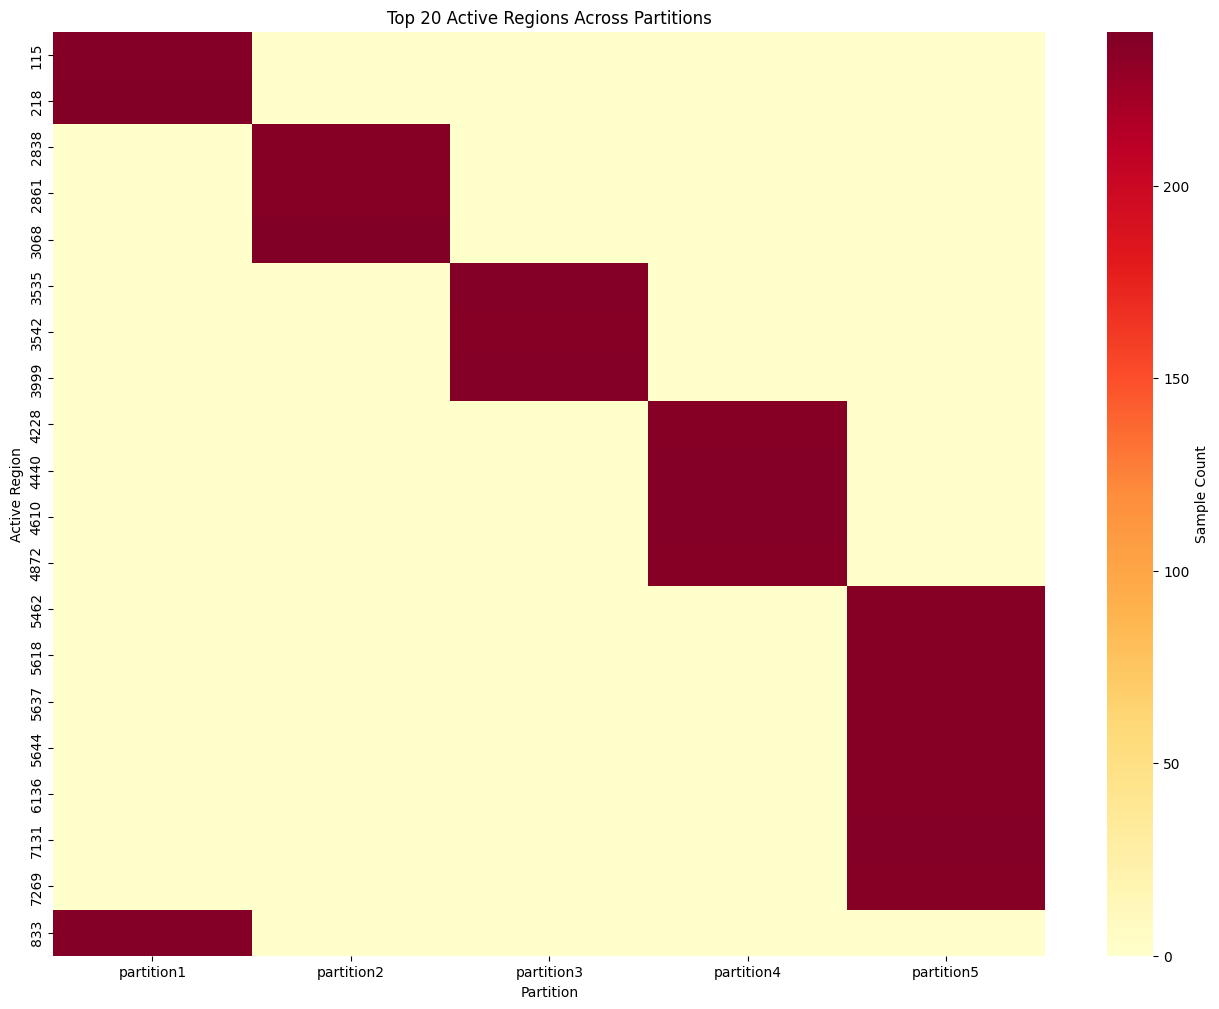

In [10]:

ar_stats = result.groupby('active_region').agg({
    'filename': 'count',  # total samples
    'class': lambda x: (x == 'FL').sum(),  # FL count
    'partition': 'nunique'  # number of partitions
}).rename(columns={'filename': 'total_samples', 'class': 'fl_count', 'partition': 'num_partitions'})
ar_stats['flare_ratio'] = ar_stats['fl_count'] / ar_stats['total_samples']


fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(1, 1, hspace=0.3, wspace=0.3)

# Actuvce region heatmap across partitions
ax2 = fig.add_subplot(gs[0])
top_ars = result['active_region'].value_counts().head(20).index
top_ar_data = result[result['active_region'].isin(top_ars)]
heatmap_data = top_ar_data.groupby(['active_region', 'partition']).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, cmap='YlOrRd', cbar_kws={'label': 'Sample Count'}, ax=ax2)
ax2.set_xlabel('Partition')
ax2.set_ylabel('Active Region')
ax2.set_title('Top 20 Active Regions Across Partitions')

plt.show()